In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
# os.environ['PROXY_URL'] = ''
from trade.helpers.Context import Context
from trade.helpers.helper import change_to_last_busday, is_USholiday, retrieve_timeseries, find_split_dates_within_range
from scipy.stats import percentileofscore
from _strategy.trend.bbands import LongBBandsTrend, LongBBandsTrend_SL
import pandas as pd
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import datetime
import yfinance as yf
import numpy as np
from scipy.stats import norm, skew, kurtosis
from trade.helpers.Logging import setup_logger
from trade.assets.Stock import Stock
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas_ta as ta
from trade.backtester_.utils.aggregators import dd, mdd, cagr
from wfa.aggregator import Aggregator, MonteCarloBacktest
from wfa.utils import load_result_dict, results_dict, get_equity_tick
import statsmodels.api as sm
from dbase.DataAPI.ThetaData import retrieve_quote, list_contracts, retrieve_eod_ohlc
import statsmodels.formula.api as smf  
logger = setup_logger('Opt_WFA_Analysis')
pd.options.plotting.backend = 'plotly'


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-06-23 21:06:22 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://34.235.162.150:5500/thetadata


In [13]:
%load_ext autoreload
%autoreload 2
import dill
path = '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/test.pkl'
with open(path, 'rb') as f:
    objects =  dill.load(f, ignore = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
load_result_dict(
    'OPTION', '180_ROLL', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/test.pkl'
)



Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl
[get_engine] Creating engine for DB: securities_master, PID: 42222
YF.download() has changed argument auto_adjust default to True
2025-06-23 21:08:06 trade.asset.Stock ERROR: Error getting previous close for BA from yfinance: 'prev_close'
2025-06-23 21:08:06 trade.asset.Stock ERROR: Error getting dividends history for TSLA from yfinance
2025-06-23 21:08:06 trade.asset.Stock ERROR: Probably due to no dividends history
2025-06-23 21:08:13 trade.asset.Stock ERROR: Error getting previous close for AMZN from yfinance: 'prev_close'
2025-06-23 21:08:14 trade.asset.Stock ERROR: Error getting dividends history for NFLX from yfinance
2025-06-23 21:08:14 trade.asset.Stock ERROR: Probably due to no dividends history


In [76]:
aggregator_sharpe = Aggregator(
                               optimization = 'OPTION', 
                                target = '180_ROLL',
                                start_overwrite = None)

[autoreload of wfa.aggregator failed: Traceback (most recent call last):
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb_new_use/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb_new_use/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb_new_use/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb_new_use/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chiemelienwanisobi/miniconda3/envs/openbb_new_use/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line

TypeError: AggregatorParent.__init__() got an unexpected keyword argument 'results'

In [47]:
aggregator_sharpe.symbol_list = objects[8]['TEST_RESULT']['BACKTESTER'].symbol_list

In [36]:
aggregator_sharpe.yearly_agg()

,Return [%],Vol Annualized [%],Sharpe,Max DrawDown [%],Max DrawDown Duration,#Trades,Win Rate [%],Expectancy [%],95 Quantile ($),5 Quantile ($),95 Quantile (%),5 Quantile (%)
datetime,,,,,,,,,,,,
2021,0.974838,1.891098,1.230063,-50.005991,194 days,32.0,43.75,21.481542,5065.678009,-3582.300000,0.175486,-0.153506
2022,-0.172644,1.149987,0.363605,-48.150853,277 days,18.0,38.89,-10.759255,3173.125000,-3027.599557,0.068269,-0.064889
2023,2.275105,3.013087,1.710403,-75.853172,151 days,29.0,58.62,25.157506,19458.200000,-17687.516359,0.329565,-0.226854
2024,1.156331,3.774729,1.785015,-64.229221,76 days,30.0,63.33,42.720713,62861.685000,-85870.715710,0.429346,-0.293784
2025,0.194187,0.799672,1.645391,-19.231267,33 days,7.0,71.43,15.388249,30215.000000,-24273.886670,0.090005,-0.065792


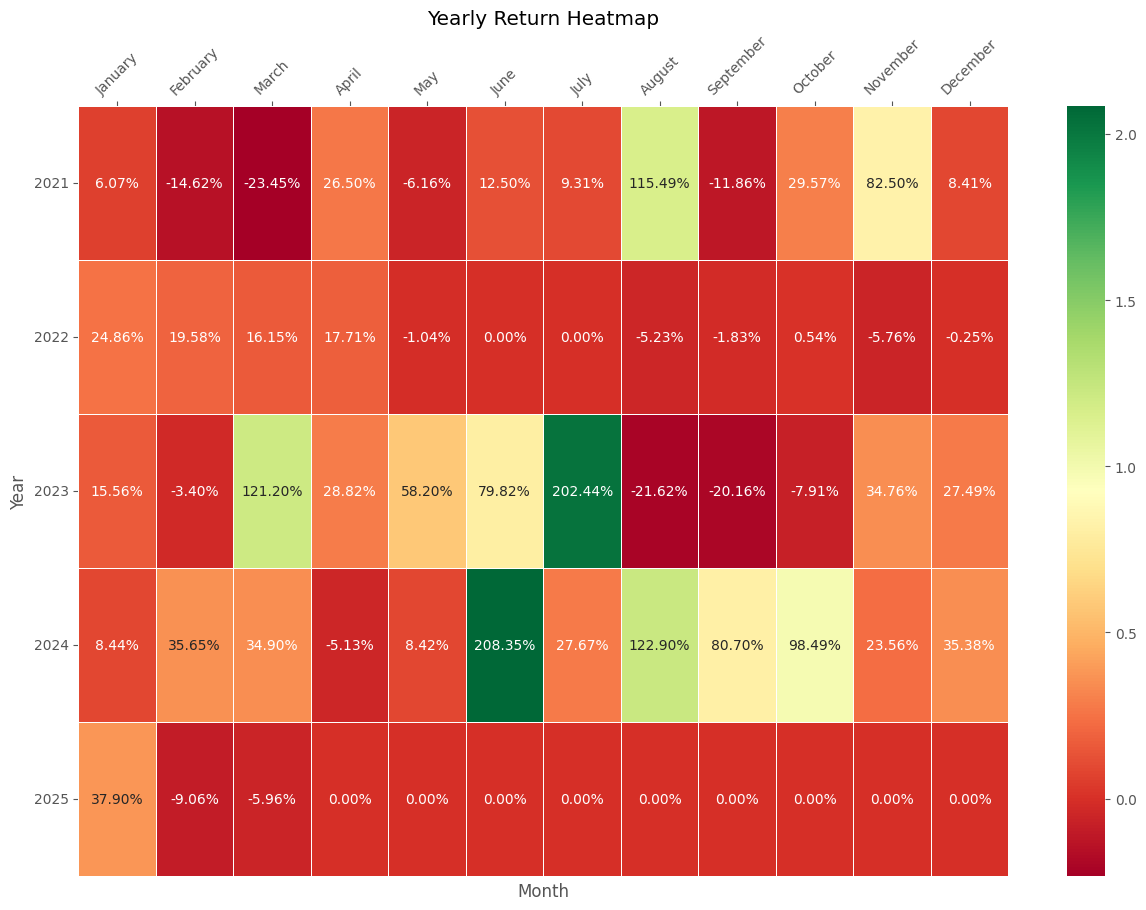

In [37]:
aggregator_sharpe.yearly_performance()

In [60]:
agg_s = aggregator_sharpe.aggregate()
agg_s

Hiya in aggregate


Start                                                    2021-01-06 00:00:00
End                                                      2025-03-03 00:00:00
Duration                                                  1517 days 00:00:00
Exposure Time [%]                                                      91.11
Equity Final [$]                                                   321159.92
Equity Peak [$]                                                406219.333805
Return [%]                                                       1524.383885
CAGR [%]                                                           95.568775
Volatility Ann. [%]                                               260.473093
Sharpe Ratio                                                        1.400715
Sortino Ratio                                                       2.135768
Skew                                                                2.754028
Calmar Ratio                                                        1.259918

In [69]:
aggregator_sharpe.backtesters

{8: <EventDriven.portfolio.OptionSignalPortfolio at 0x14bfe0f50>,
 9: <EventDriven.portfolio.OptionSignalPortfolio at 0x14d4a1250>,
 10: <EventDriven.portfolio.OptionSignalPortfolio at 0x150fb1950>,
 11: <EventDriven.portfolio.OptionSignalPortfolio at 0x153837a50>,
 12: <EventDriven.portfolio.OptionSignalPortfolio at 0x155ae5e50>}

In [64]:
aggregator_sharpe._trades.rename(columns = {'EntryQuantity': 'Size'}, inplace = True)

In [65]:
aggregator_sharpe.plot_portfolio()

In [18]:
class EVBOptionAggregator(AggregatorParent):

    def __init__(self, objects):
        self.objects = objects

KeyError: 'TARGET_OPTIMIZATION'